# Gradient Descent

In [20]:
import pandas as pd 
import numpy as np

from sklearn.metrics import mean_squared_error 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor

import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
import mlflow
from modeling.config import EXPERIMENT_NAME
TRACKING_URI = open("../.mlflow_uri").read().strip()

In [8]:
# read data
df = pd.read_csv('../data/Featureselection03.csv')
df.head()

,EntryDate,AB.FMS.act.tPh,AB.FTS.act.dgC,DDM.AFTCL.act.m,DDM.FWDCL.act.m,DDM.MIDPS.act.m,DDM.MIDSB.act.m,HFO.GME.act.nodim,ME.EFF.act.PRC,ME.FMS.act.tPh,...,Heading_Dir_deg_daily,True_Wind_Speed_mPs_daily,True_Wind_Dir_deg_daily,Wave_Height_m_daily,True_Wave_Dir_deg_daily,trip_id,Power_EM_predict,DDM.TRIM.act.m,DDM.DRAFT.act.m,DDM.HEEL.act.m
0,2021-05-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,80.0,6.7,109.0,0.5,289.0,1,14563.73,1.021,0.1276,0.2552
1,2021-05-31 00:01:00,0.003108,82.858482,13.309999,14.788999,13.924999,13.587000,1.0,50.766113,3.353553,...,80.0,6.7,109.0,0.5,289.0,2,14563.73,1.021,0.1276,0.2552
2,2021-05-31 00:02:00,0.001970,82.832756,13.444999,14.363999,13.320999,13.378999,1.0,50.982193,3.305582,...,80.0,6.7,109.0,0.5,289.0,2,14563.73,1.021,0.1276,0.2552
3,2021-05-31 00:03:00,0.000000,82.795395,13.381999,14.321000,14.242000,13.584000,1.0,51.326881,3.288588,...,80.0,6.7,109.0,0.5,289.0,2,14563.73,1.021,0.1276,0.2552
4,2021-05-31 00:04:00,0.000000,82.884254,13.365999,14.745000,14.094998,13.596999,1.0,52.311672,3.239272,...,80.0,6.7,109.0,0.5,289.0,2,14563.73,1.021,0.1276,0.2552


In [9]:
# read list with feature importance
data_log = pd.read_csv('../data/Capstone_features_Features.csv')
data_log.head()

,VarName,F_Imp_new,ModelImportance
0,LM1.plc_skewtime.act.s,3,3
1,LM1.plc_skewtime.max.s,3,3
2,LM1.plc_uptime.act.s,3,3
3,LM1.plc_cpuload.avg_5s.PRC,3,3
4,LM1.plc_timeBalance.act.s,3,3


### Create data frame with important features

In [10]:
# create list of important features (feature importance < 3)
list_imp_feat = list(data_log[data_log['ModelImportance'] < 3]['VarName'])
len(list_imp_feat)

18

In [11]:
df_model = df[list_imp_feat].copy()

In [12]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211679 entries, 0 to 211678
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ME.FMS.act.tPh           210961 non-null  float64
 1   ME.FTS.act.dgC           210961 non-null  float64
 2   HFO.GME.act.nodim        210961 non-null  float64
 3   V.COG.act.deg            210885 non-null  float64
 4   V.SOG.act.kn             210885 non-null  float64
 5   V.RUA.act.deg            210885 non-null  float64
 6   V.GPSLAT.act.deg         210885 non-null  float64
 7   V.GPSLON.act.deg         210885 non-null  float64
 8   WEA.WDT.act.deg          210814 non-null  float64
 9   WEA.WST.act.mPs          210884 non-null  float64
 10  V.SLPOG.act.PRC          136969 non-null  float64
 11  ME.SFCI.act.gPkWh        136929 non-null  float64
 12  DDM.TRIM.act.m           211679 non-null  float64
 13  DDM.DRAFT.act.m          211679 non-null  float64
 14  pass

### Fill and drop NaN

In [13]:
df_model['V.SLPOG.act.PRC'].fillna(0,inplace=True)
df_model['ME.SFCI.act.gPkWh'].fillna(0,inplace=True)

In [14]:
df_model.dropna(inplace=True)

In [15]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180149 entries, 1 to 211678
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ME.FMS.act.tPh           180149 non-null  float64
 1   ME.FTS.act.dgC           180149 non-null  float64
 2   HFO.GME.act.nodim        180149 non-null  float64
 3   V.COG.act.deg            180149 non-null  float64
 4   V.SOG.act.kn             180149 non-null  float64
 5   V.RUA.act.deg            180149 non-null  float64
 6   V.GPSLAT.act.deg         180149 non-null  float64
 7   V.GPSLON.act.deg         180149 non-null  float64
 8   WEA.WDT.act.deg          180149 non-null  float64
 9   WEA.WST.act.mPs          180149 non-null  float64
 10  V.SLPOG.act.PRC          180149 non-null  float64
 11  ME.SFCI.act.gPkWh        180149 non-null  float64
 12  DDM.TRIM.act.m           180149 non-null  float64
 13  DDM.DRAFT.act.m          180149 non-null  float64
 14  pass

### Check correlations

<AxesSubplot:>

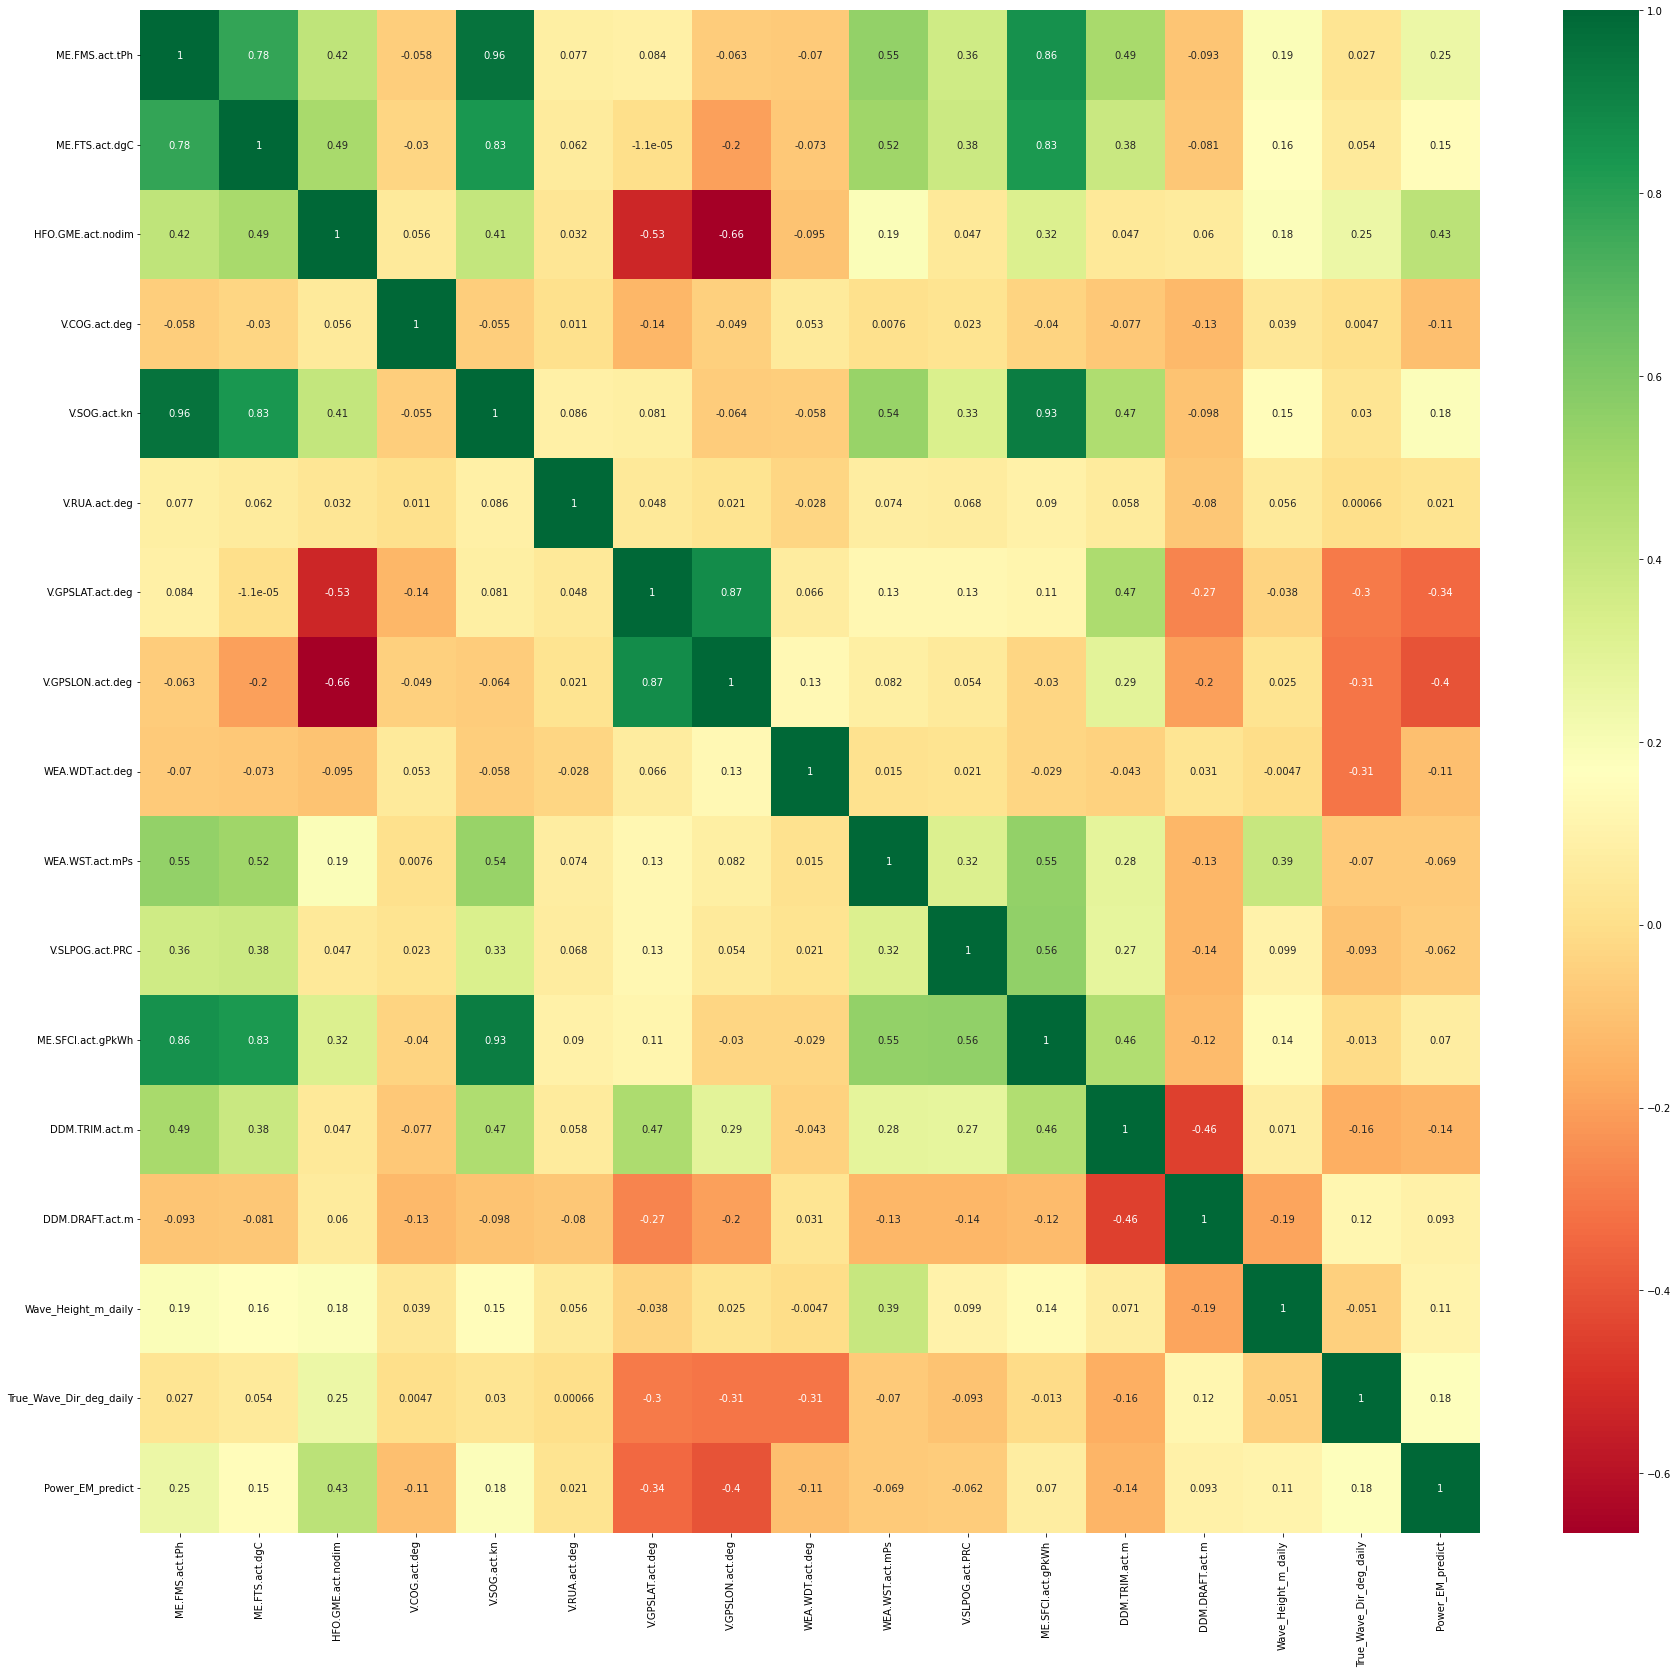

In [16]:
plt.figure(figsize = (30,28))
sns.heatmap(df_model.corr(), annot = True, cmap = 'RdYlGn')

### Define Target

In [17]:
X = df_model.drop(['ME.FMS.act.tPh'], axis = 1)
y = df_model['ME.FMS.act.tPh']

### Train Test Split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = X['passage_type'], test_size = 0.1, random_state = 42)

### Create dummy values for feature 'passage_type'

In [19]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

### Set MLFlow connection

In [30]:
# setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.start_run(run_name='SGDRegressor') # CHANGE!
run = mlflow.active_run()

## Modelling

In [21]:
reg = make_pipeline(MinMaxScaler(), SGDRegressor(max_iter=1000, tol=1e-3)) # CHANGE!

In [22]:
reg.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('sgdregressor', SGDRegressor())])

In [23]:
y_pred = reg.predict(X_test)
y_pred_train = reg.predict(X_train)

## Analysis

In [24]:
print('RMSE train: ', mean_squared_error(y_train, y_pred_train, squared= False))
rmse_train = mean_squared_error(y_train, y_pred_train, squared= False)
print('RMSE test: ', mean_squared_error(y_test, y_pred, squared= False))
rmse_test = mean_squared_error(y_test, y_pred, squared= False)

RMSE train:  0.40883050064735227
RMSE test:  0.4107529142854367


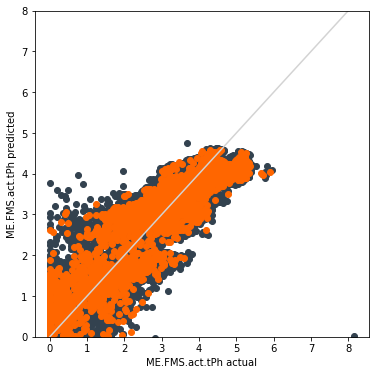

In [26]:
fig=plt.figure(figsize=(6, 6))
plt.axline([1, 1], [2, 2],color='lightgrey')
plt.scatter(y_train, y_pred_train, color ='#33424F')
plt.scatter(y_test, y_pred, color = '#FF6600')
#plt.xticks(np.arange(0,501,100));
#plt.yticks(np.arange(0,501,100));
plt.xlabel("ME.FMS.act.tPh actual");
plt.ylabel("ME.FMS.act.tPh predicted");
#plt.xlim(0, 8);
plt.ylim(0, 8);

### Write to MLFlow

In [31]:
#seting parameters that should be logged on MLFlow
#these parameters were used in feature engineering (inputing missing values)
#or parameters of the model (fit_intercept for Linear Regression model)
params = {
      "features drop": 'according to Capstone_features_Features.csv',
      "explanation": '',
      "csv used": 'Featureselection03.csv',
      "NaN handling": 'V.SLPOG.act.PRC and ME.SFCI.act.gPkWh filled with 0, rest dropped by row',
      'Shape' : df.shape,
      'Scaler' : 'MinMaxScaler',
      'max_iter' : 1000, 
      'tol' : 1e-3
  }

In [32]:
#logging params to mlflow
mlflow.log_params(params)
#setting tags
mlflow.set_tag("running_from_jupyter", "True")
#logging metrics
mlflow.log_metric("train-" + "RMSE", rmse_train)
mlflow.log_metric("test-" + "RMSE", rmse_test)
# logging the model to mlflow will not work without a AWS Connection setup.. too complex for now
# but possible if running mlflow locally
# mlflow.log_artifact("../models")
# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

### What are the most important features?

In [27]:
X_train.columns

Index(['ME.FTS.act.dgC', 'HFO.GME.act.nodim', 'V.COG.act.deg', 'V.SOG.act.kn',
       'V.RUA.act.deg', 'V.GPSLAT.act.deg', 'V.GPSLON.act.deg',
       'WEA.WDT.act.deg', 'WEA.WST.act.mPs', 'V.SLPOG.act.PRC',
       'ME.SFCI.act.gPkWh', 'DDM.TRIM.act.m', 'DDM.DRAFT.act.m',
       'Wave_Height_m_daily', 'True_Wave_Dir_deg_daily', 'Power_EM_predict',
       'passage_type_Europe<13.5kn', 'passage_type_Europe>13.5kn',
       'passage_type_SouthAmerica<13.5kn', 'passage_type_SouthAmerica>13.5kn'],
      dtype='object')

In [28]:
reg.steps[1][1].coef_

array([-0.69626563,  0.0219273 ,  0.03963957,  3.86671079, -0.52354113,
        0.25704372, -0.34329914, -0.04432887,  0.80002629,  2.05075   ,
       -0.71183198,  1.31636775,  0.27718427,  0.21015486, -0.03917062,
        1.02414681, -0.6327483 , -0.21448383, -0.95815955,  0.09269128])

In [29]:
df_coef = pd.DataFrame({'features' : X_train.columns, 'coef' : reg.steps[1][1].coef_})
df_coef.sort_values('coef')

,features,coef
18,passage_type_SouthAmerica<13.5kn,-0.958160
10,ME.SFCI.act.gPkWh,-0.711832
0,ME.FTS.act.dgC,-0.696266
16,passage_type_Europe<13.5kn,-0.632748
4,V.RUA.act.deg,-0.523541
6,V.GPSLON.act.deg,-0.343299
17,passage_type_Europe>13.5kn,-0.214484
7,WEA.WDT.act.deg,-0.044329
14,True_Wave_Dir_deg_daily,-0.039171
1,HFO.GME.act.nodim,0.021927
